In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from scipy.optimize import curve_fit
from scipy.optimize import linear_sum_assignment
import tqdm
import pickle 




from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
LS133 = "./ntupleStubsBmtfGmt_LS133.root"
LS263 = "./ntupleStubsBmtfGmt_LS263.root"
LS264 = "./ntupleStubsBmtfGmt_LS264.root"
LS306 = "./ntupleStubsBmtfGmt_LS306.root"

#Open file
gmt_awk_LS133 = OpenRootFile(LS133, gmt_features)
gmt_awk_LS263 = OpenRootFile(LS263, gmt_features)
gmt_awk_LS264 = OpenRootFile(LS264, gmt_features)
gmt_awk_LS306 = OpenRootFile(LS306, gmt_features)

bmtf_awk_LS133 = OpenRootFile(LS133, bmtf_features)
bmtf_awk_LS263 = OpenRootFile(LS263, bmtf_features)
bmtf_awk_LS264 = OpenRootFile(LS264, bmtf_features)
bmtf_awk_LS306 = OpenRootFile(LS306, bmtf_features)

In [3]:
GmtEtaLS133 = gmt_awk_LS133.gmtEta
GmtEtaLS263 = gmt_awk_LS263.gmtEta
GmtEtaLS264 = gmt_awk_LS264.gmtEta
GmtEtaLS306 = gmt_awk_LS306.gmtEta

GmtPhiLS133 = gmt_awk_LS133.gmtPhi
GmtPhiLS263 = gmt_awk_LS263.gmtPhi
GmtPhiLS264 = gmt_awk_LS264.gmtPhi
GmtPhiLS306 = gmt_awk_LS306.gmtPhi

GmtPtLS133 = gmt_awk_LS133.gmtPt
GmtPtLS263 = gmt_awk_LS263.gmtPt
GmtPtLS264 = gmt_awk_LS264.gmtPt
GmtPtLS306 = gmt_awk_LS306.gmtPt


nGmtMuons_LS133 = gmt_awk_LS133.nGmtMuons
nGmtMuons_LS263 = gmt_awk_LS263.nGmtMuons
nGmtMuons_LS264 = gmt_awk_LS264.nGmtMuons
nGmtMuons_LS306 = gmt_awk_LS306.nGmtMuons


#-----------------------------------------------BMTF-----------------------------------------------

BmtfEtaLS133 = bmtf_awk_LS133.bmtfEta
BmtfEtaLS263 = bmtf_awk_LS263.bmtfEta
BmtfEtaLS264 = bmtf_awk_LS264.bmtfEta
BmtfEtaLS306 = bmtf_awk_LS306.bmtfEta

BmtfPhiLS133 = bmtf_awk_LS133.bmtfPhi
BmtfPhiLS263 = bmtf_awk_LS263.bmtfPhi
BmtfPhiLS264 = bmtf_awk_LS264.bmtfPhi
BmtfPhiLS306 = bmtf_awk_LS306.bmtfPhi

BmtfPtLS133 = bmtf_awk_LS133.bmtfPt
BmtfPtLS263 = bmtf_awk_LS263.bmtfPt
BmtfPtLS264 = bmtf_awk_LS264.bmtfPt
BmtfPtLS306 = bmtf_awk_LS306.bmtfPt


nBmtfMuons_LS133 = bmtf_awk_LS133.nBmtfMuons
nBmtfMuons_LS263 = bmtf_awk_LS263.nBmtfMuons
nBmtfMuons_LS264 = bmtf_awk_LS264.nBmtfMuons
nBmtfMuons_LS306 = bmtf_awk_LS306.nBmtfMuons

GmtEta = ak.concatenate((GmtEtaLS133, GmtEtaLS263, GmtEtaLS264, GmtEtaLS306))
BmtfEta = ak.concatenate((BmtfEtaLS133, BmtfEtaLS263, BmtfEtaLS264, BmtfEtaLS306))
GmtPhi = ak.concatenate((GmtPhiLS133, GmtPhiLS263, GmtPhiLS264, GmtPhiLS306))
BmtfPhi = ak.concatenate((BmtfPhiLS133, BmtfPhiLS263, BmtfPhiLS264, BmtfPhiLS306))
GmtPt = ak.concatenate((GmtPtLS133, GmtPtLS263, GmtPtLS264, GmtPtLS306))
BmtfPt = ak.concatenate((BmtfPtLS133, BmtfPtLS263, BmtfPtLS264, BmtfPtLS306))
nBmtfMuons = ak.concatenate((nBmtfMuons_LS133, nBmtfMuons_LS263, nBmtfMuons_LS264, nBmtfMuons_LS306))
nGmtMuons = ak.concatenate((nGmtMuons_LS133, nGmtMuons_LS263, nGmtMuons_LS264, nGmtMuons_LS306))



In [4]:
def Delta(BMTF, GMT):
  return BMTF - GMT

def DeltaR(BmtfPhi, GmtPhi, BmtfEta, GmtEta):
  return np.sqrt((BmtfPhi - GmtPhi)**2 + (BmtfEta - GmtEta)**2)

In [5]:
def CheckDuplicates(j, IndexMin, DeltaRDist, DeltaRTemp, indexTemp):
  
  IndexMin.pop(j)
  #Creo una maschera per il vecchio minimo
  Mask = np.ones(DeltaRTemp.shape, dtype=bool)
  Mask[indexTemp] = False
  Sec_minDeltaR = np.min(DeltaRTemp[Mask])
  #Trovo il nuovo minimo, applicando la maschera a DeltaRTemp
  Sec_indexTemp = np.argwhere((DeltaRTemp == Sec_minDeltaR) & Mask)[0][0]

  DeltaRDist.append(Sec_minDeltaR)
  IndexMin.append(Sec_indexTemp)

  return DeltaRDist, IndexMin

def DeltaRDist(nBmtfMuons, nGmtMuons, Bmtf_Phi, Gmt_Phi, Bmtf_Eta, Gmt_Eta, Bmtf_Pt, Gmt_Pt, Number):
  MuonsProperties = []

  for i in tqdm.tqdm(range(Number)):

    #Fare in questo modo ottimizza enormemente il processo!
    nBmtfM, nGmtM = nBmtfMuons[i], nGmtMuons[i]
    ArrBmtfPhi, ArrBmtfEta = ak.to_numpy(Bmtf_Phi[i]), ak.to_numpy(Bmtf_Eta[i])
    ArrGmtPhi, ArrGmtEta = ak.to_numpy(Gmt_Phi[i]), ak.to_numpy(Gmt_Eta[i])
    ArrBmtfPt, ArrGmtPt = ak.to_numpy(Bmtf_Pt[i]), ak.to_numpy(Gmt_Pt[i])


    DeltaRDistBMTF, DeltaRDistGMT = [], []
    IndexMinBMTF, IndexMinGMT = [], []
    PtBMTF, PtGMT = [], []

    ArrDeltaPhiBMTF, ArrDeltaEtaBMTF = [], []
    ArrDeltaPhiGMT, ArrDeltaEtaGMT = [], []


    if nGmtM == 0 and nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = []
    
    elif nBmtfM == 0:
      unmatched_Bmtf = []
      unmatched_Gmt = [i for i in range(nGmtM)]

    elif nGmtM == 0:
      unmatched_Bmtf = [i for i in range(nBmtfM)]
      unmatched_Gmt = []


    else:
      #Primo metodo 
      for j in range(nBmtfM):

        #Calcolo il DeltaR
        DeltaRTemp = DeltaR(ArrBmtfPhi[j], ArrGmtPhi[:], ArrBmtfEta[j], ArrGmtEta[:])

        #Attento a come sono definiti IndexMin nei vari casi! Nel primo caso è confronto con tutti i muoni del GMT!
        minDeltaR = np.min(DeltaRTemp)
        indexTempGMT = np.argmin(DeltaRTemp)
        IndexMinGMT.append(indexTempGMT)

        if minDeltaR < 0.4:
          
          #Controllo che non vengano assegnati gli stessi indici dei minimi a muoni diversi
          if IndexMinGMT[j] in IndexMinGMT[:j] and nBmtfM == nGmtM:

            DeltaRDistBMTF, IndexMinGMT = CheckDuplicates(j, IndexMinGMT, DeltaRDistBMTF, DeltaRTemp, indexTempGMT)
                          

          else:
            DeltaRDistBMTF.append(minDeltaR)

          DeltaPhi_BMTF = Delta(ArrBmtfPhi[j], ArrGmtPhi[IndexMinGMT[j]])
          DeltaEta_BMTF = Delta(ArrBmtfEta[j], ArrGmtEta[IndexMinGMT[j]])
          ArrDeltaPhiBMTF.append(DeltaPhi_BMTF)
          ArrDeltaEtaBMTF.append(DeltaEta_BMTF)

          
        else:
          #Se DeltaR > 0.4 (primo metodo) non c'è match con i muoni del GMT
          unmatched_Gmt = [i for i in range(nGmtM)]
    
      
        matched_Bmtf_Index = [i for i in IndexMinGMT if IndexMinGMT]
        unmatched_Bmtf = [i for i in range(nBmtfM) if i not in matched_Bmtf_Index]
        

      #Secondo metodo 
      for k in range(nGmtM):
        DeltaRTemp = DeltaR(ArrBmtfPhi[:], ArrGmtPhi[k], ArrBmtfEta[:], ArrGmtEta[k])

        minDeltaR = np.min(DeltaRTemp)
        indexTempBMTF = np.argmin(DeltaRTemp)
        IndexMinBMTF.append(indexTempBMTF)

        if minDeltaR < 0.4:
          
          if IndexMinBMTF[k] in IndexMinBMTF[:k] and nBmtfM == nGmtM:
          
            DeltaRDistGMT, IndexMinBMTF = CheckDuplicates(k, IndexMinBMTF, DeltaRDistGMT, DeltaRTemp, indexTempBMTF)
          
          else:
            DeltaRDistGMT.append(minDeltaR)

          DeltaPhi_GMT = Delta(ArrBmtfPhi[IndexMinBMTF[k]], ArrGmtPhi[k])
          DeltaEta_GMT = Delta(ArrBmtfEta[IndexMinBMTF[k]], ArrGmtEta[k])
          ArrDeltaPhiGMT.append(DeltaPhi_GMT)
          ArrDeltaEtaGMT.append(DeltaEta_GMT)
          PtBMTF.append(ArrBmtfPt[IndexMinBMTF[k]])
          PtGMT.append(ArrGmtPt[k])
          
        else:
          unmatched_Bmtf = [i for i in range(nBmtfM)]


    Events = {
      'unmatched_Gmt_Events' : unmatched_Gmt,
      'unmatched_Bmtf_Events': unmatched_Bmtf, 
      'nGmtMuons': nGmtM,
      'nBmtfMuons': nBmtfM,
      'DeltaPhiBMTF': ArrDeltaPhiBMTF,
      'DeltaEtaBMTF': ArrDeltaEtaBMTF,
      'DeltaPhiGMT': ArrDeltaPhiGMT,
      'DeltaEtaGMT': ArrDeltaEtaGMT,
      #Solo i Pt che hanno fatto il match
      'PtBMTF': PtBMTF,
      'PtGMT': PtGMT, 
      # tutti i Pt
      'AllPtBMTF': ArrBmtfPt,
      'AllPtGMT': ArrGmtPt

    }

    MuonsProperties.append(Events)



  return MuonsProperties

In [6]:
#MuonsProperties = DeltaRDist(nBmtfMuons, nGmtMuons, BmtfPhi, GmtPhi, BmtfEta, GmtEta, BmtfPt, GmtPt, Number = len(nBmtfMuons))

100%|██████████| 11604754/11604754 [38:41<00:00, 4999.50it/s] 


In [20]:
'''with open('MuonsProperties.pkl', 'wb') as f:
    pickle.dump(MuonsProperties, f)'''
        
with open('MuonsProperties.pkl', 'rb') as f:
    MuonsProperties = pickle.load(f)

In [21]:
MuonsProperties = ak.Array(MuonsProperties)

In [22]:
print("# of unmatched BMTF = ", ak.sum(ak.num(MuonsProperties.unmatched_Bmtf_Events)))
print("# of unmatched GMT = ", ak.sum(ak.num(MuonsProperties.unmatched_Gmt_Events)))

Tot_Unmatched_GMT = ak.sum(ak.num(MuonsProperties.unmatched_Gmt_Events))
Tot_Unmatched_BMTF = ak.sum(ak.num(MuonsProperties.unmatched_Bmtf_Events))

Tot_Matched_GMT = ak.sum(MuonsProperties.nGmtMuons)
Tot_Matched_BMTF = ak.sum(MuonsProperties.nBmtfMuons)

fractionBMTF = Tot_Unmatched_BMTF / Tot_Matched_BMTF * 100
fractionGMT = Tot_Unmatched_GMT / Tot_Matched_GMT * 100

print(f"unmatchedGMT: {fractionGMT:.2f}, unmatchedBMTF: {fractionBMTF:.2f}")

# of unmatched BMTF =  126193
# of unmatched GMT =  4914
unmatchedGMT: 0.23, unmatchedBMTF: 5.58


# Matching efficiency 

In [10]:
PtBMTF = ak.flatten(MuonsProperties.PtBMTF)
PtGMT = ak.flatten(MuonsProperties.PtGMT)

AllPtBMTF = ak.flatten(MuonsProperties.AllPtBMTF)
AllPtGMT = ak.flatten(MuonsProperties.AllPtGMT)

bins = np.array([0, 5, 10, 15, 20, 30, 40, 50, 100, 300])
#bins = np.array([0, 1, 2, 4, 8, 16, 32, 64, 128, 256])
#bins = np.array([1, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50, 75, 100, 150, 256])

BMTFMatchingEfficiency = np.zeros(len(bins))
GMTMatchingEfficiency = np.zeros(len(bins))

PtBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="pTBMTF", label="BMTF Muon pT [GeV]"))
AllPtBMTF_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTBMTF", label="BMTF Muon pT [GeV]"))

PtBMTF_Hist.fill(pTBMTF=PtBMTF)
AllPtBMTF_Hist.fill(AllpTBMTF=AllPtBMTF)


for i in range(len(bins) - 1):
 
  TempEff = PtBMTF_Hist[i] / AllPtBMTF_Hist[i]
  BMTFMatchingEfficiency[i] = TempEff

PtGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="pTGMT", label="GMT Muon pT [GeV]"))
AllPtGMT_Hist = hist.Hist(hist.axis.Variable(bins, name="AllpTGMT", label="GMT Muon pT [GeV]"))

PtGMT_Hist.fill(pTGMT=PtGMT)
AllPtGMT_Hist.fill(AllpTGMT=AllPtGMT)

for i in range(len(bins) - 1):
 
  TempEff = PtGMT_Hist[i] / AllPtGMT_Hist[i]
  GMTMatchingEfficiency[i] = TempEff

print(BMTFMatchingEfficiency)
print(GMTMatchingEfficiency)

[0.97574533 0.91383009 0.89149891 0.90204995 0.90947547 0.92998605
 0.93410616 0.9535765  0.98433243 0.        ]
[0.99755979 0.99898796 0.99864459 0.99804983 0.99715076 0.99465558
 0.99548969 0.99559902 0.99187542 0.        ]


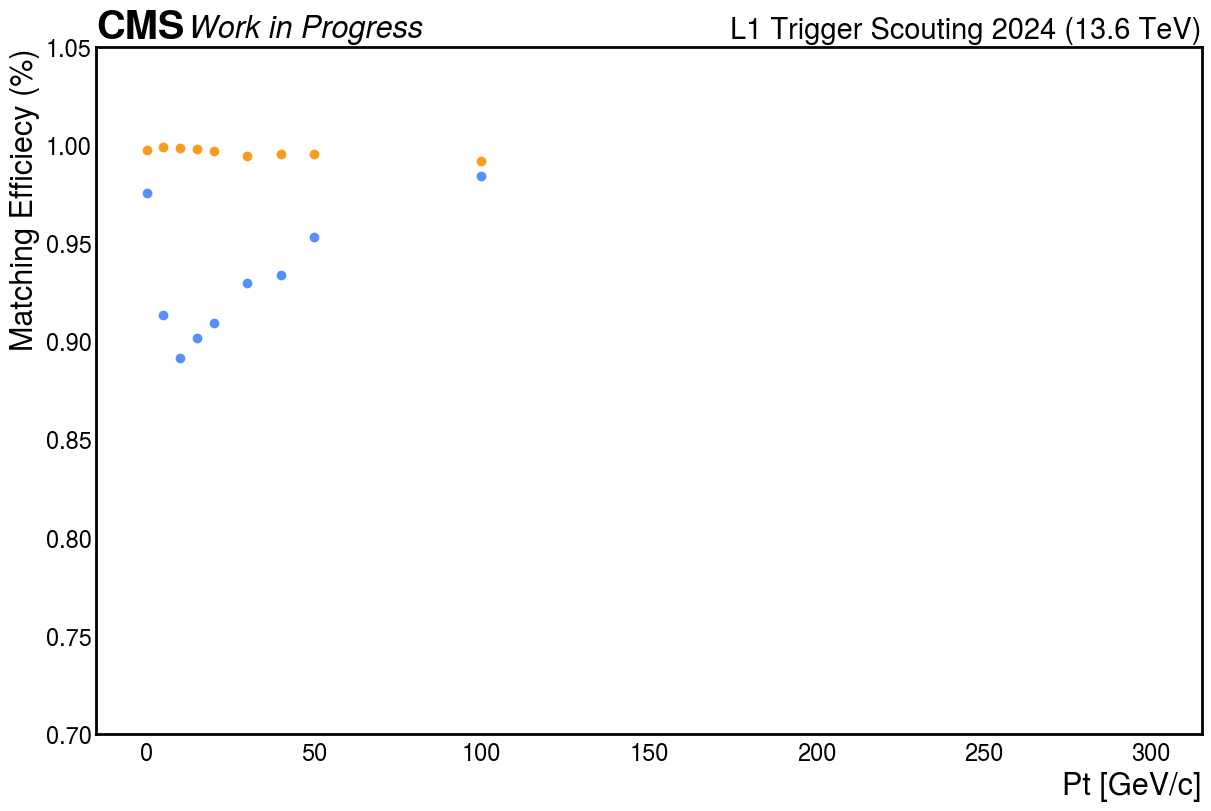

In [15]:
fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

#hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())


plt.scatter(bins, BMTFMatchingEfficiency)
plt.scatter(bins, GMTMatchingEfficiency)

ax.set_ylim(0.7, 1.05)


ax.set_xlabel(r'Pt [GeV/c]')
ax.set_ylabel('Matching Efficiecy (%)')
ax.grid(False)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)

plt.show()

# Grafici

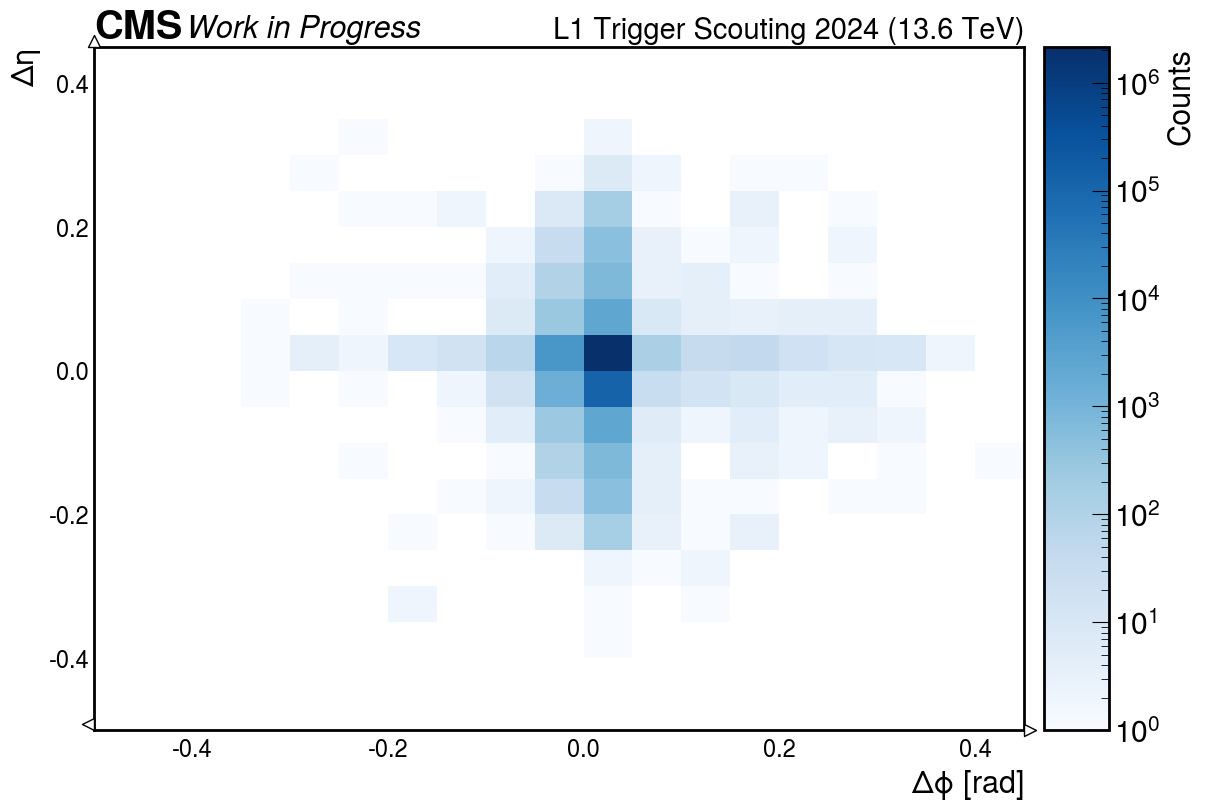

In [16]:
DeltaPhi_BMTF = MuonsProperties.DeltaPhiBMTF
DeltaEta_BMTF = MuonsProperties.DeltaEtaBMTF

a = 0.5
DeltaPhiRange = np.arange(-a, a, 0.05)
DeltaEtaRange = np.arange(-a, a, 0.05)

hist2d = hist.Hist(
    hist.axis.Variable(DeltaPhiRange, name='Phi'),
    hist.axis.Variable(DeltaEtaRange, name='Eta')

)
hist2d.fill(Phi=ak.flatten(DeltaPhi_BMTF), Eta=ak.flatten(DeltaEta_BMTF))

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())

cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=FONTSIZE)

ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'$\Delta \eta$')
ax.grid(False)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)


'''plt.savefig("../Immagini/BMTFPhiEta.pdf")
plt.savefig("../Immagini/ImmaginiPNG/BMTFPhiEta.png")'''

plt.show()

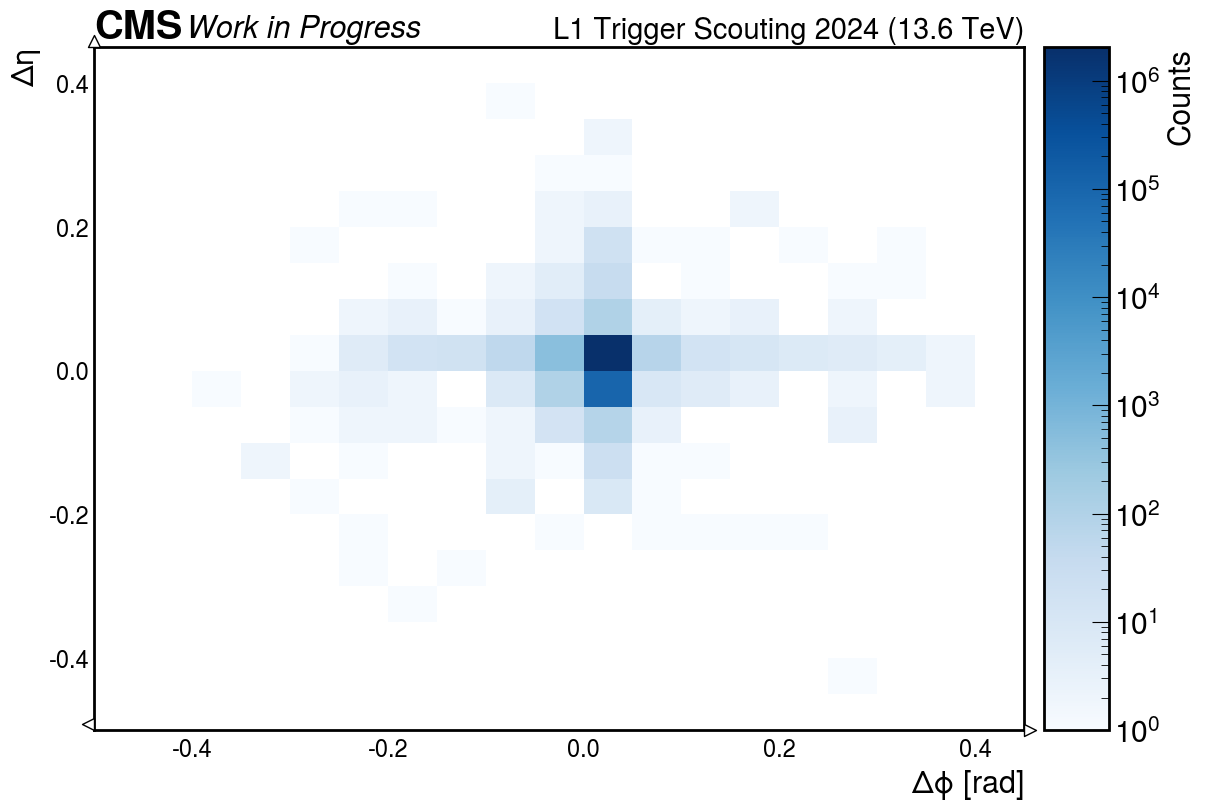

In [17]:
DeltaPhi_GMT = MuonsProperties.DeltaPhiGMT
DeltaEta_GMT = MuonsProperties.DeltaEtaGMT

a = 0.5
DeltaPhiRange = np.arange(-a, a, 0.05)
DeltaEtaRange = np.arange(-a, a, 0.05)

hist2d = hist.Hist(
    hist.axis.Variable(DeltaPhiRange, name='Phi'),
    hist.axis.Variable(DeltaEtaRange, name='Eta')

)
hist2d.fill(Phi=ak.flatten(DeltaPhi_GMT), Eta=ak.flatten(DeltaEta_GMT))

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(12, 8), constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize=FONTSIZE, label="Work in Progress", rlabel="L1 Trigger Scouting 2024 (13.6 TeV)")

hep.hist2dplot(hist2d, cbar=True, cmap='Blues', ax=ax,  norm = LogNorm())

cbar = ax.collections[0].colorbar
cbar.set_label('Counts', fontsize=FONTSIZE)

ax.set_xlabel(r'$\Delta \phi$ [rad]')
ax.set_ylabel(r'$\Delta \eta$')
ax.grid(False)

ax.tick_params(axis='both', which='both', length=0, labelsize = FONTSIZE - 5)


plt.savefig("../Immagini/GMTPhiEta.pdf")
plt.savefig("../Immagini/ImmaginiPNG/GMTPhiEta.png")

plt.show()

# Matching Efficiency 